# 1. Introduction
### 1.1 Goal: Predict House Prices
__(info on slide)__
### 1.2 Dataset: Ames, Iowa Housing Market Data
__Abstract Excerpt:__

This paper presents a data set describing the sale of individual residential property in Ames, Iowa from 2006 to 2010. The data set contains 2930 observations and a large number of explanatory variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous) involved in assessing home values.

__Full Description:__

https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

__Data Source:__

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

### 1.2 Dataset: Ames, Iowa Housing Market Data
__Abstract Excerpt:__

This paper presents a data set describing the sale of individual residential property in Ames, Iowa from 2006 to 2010. The data set contains 2930 observations and a large number of explanatory variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous) involved in assessing home values.

__Full Description:__

https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

__Data Source:__

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [52]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

from scipy import stats
from scipy.stats import norm, skew

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import linear_model, ensemble
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR

import xgboost as xgb
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')
%matplotlib inline

In [53]:
#set seaborn plot display options
sns.set(style='darkgrid', palette='muted', font_scale=1.2)

#color variables incase they're needed
color_b = sns.color_palette('muted').as_hex()[0]
color_g = sns.color_palette('muted').as_hex()[1]
color_r = sns.color_palette('muted').as_hex()[2]
color_p = sns.color_palette('muted').as_hex()[3]
color_y = sns.color_palette('muted').as_hex()[4]
color_c = sns.color_palette('muted').as_hex()[5]

# 2. Data upload, cleaning, & preprocessing
### Upload & basic cleaning

In [54]:
#upload data
train_raw = pd.read_csv('train.csv')
test_raw = pd.read_csv('test.csv')

In [55]:
#concat indepent variables to single df
#started at mssubclass to drop 'id' column
#id contains no meaninful info for predicint saleprice
df = pd.concat((train_raw.loc[:,'MSSubClass':'SaleCondition'],
                test_raw.loc[:,'MSSubClass':'SaleCondition']))
#lowercase column names
df.columns = [x.lower() for x in df.columns]
#strip whitespace
to_strip = df.select_dtypes(include='object')
df[to_strip.columns] = to_strip.apply(lambda x: x.str.strip())

In [56]:
#perform the same on df where saleprices are
train = train_raw.copy()
train.columns = [x.lower() for x in train.columns]
#strip whitespace
to_strip = train.select_dtypes(include='object')
train[to_strip.columns] = to_strip.apply(lambda x: x.str.strip())

### 2.1 Outliers

The [dataset documentation](https://ww2.amstat.org/publications/jse/v19n3/decock.pdf) points out a few problematic outliers, and recommends removing records where grlivarea > 4000

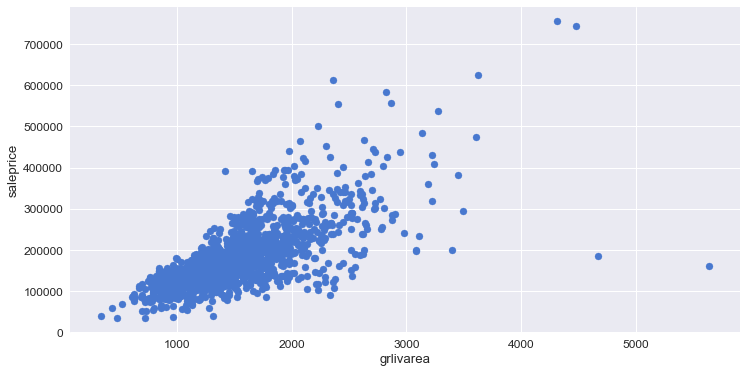

In [57]:
plt.figure(figsize=(12,6))
plt.scatter(train['grlivarea'], train['saleprice'])
plt.xlabel('grlivarea')
plt.ylabel('saleprice')
plt.show()

In [58]:
#remove outliers from datasets
df = df[df.grlivarea < 4000]
train = train[train.grlivarea < 4000]

### 2.2 Address missingness

In [59]:
#missing data
missing_data = df.isnull().sum().sort_values(ascending=False)
missing_data = missing_data.reset_index()
missing_data.columns = ['variable','rows_missing']
missing_data = missing_data[missing_data['rows_missing'] > 0]
missing_data

,variable,rows_missing
0,poolqc,2906
1,miscfeature,2809
2,alley,2716
3,fence,2344
4,fireplacequ,1420
5,lotfrontage,486
6,garagecond,159
7,garagequal,159
8,garageyrblt,159
9,garagefinish,159


In [60]:
#impute none or 0 where applicable
df['poolqc'].fillna('none', inplace=True)
df['miscfeature'].fillna('none', inplace=True)
df['alley'].fillna('none', inplace=True)
df['fence'].fillna('none', inplace=True)
df['fireplacequ'].fillna('none', inplace=True)
df['garagecond'].fillna('none', inplace=True) #consider revisiting
df['garagetype'].fillna('none', inplace=True)
df['garagefinish'].fillna('none', inplace=True)
df['garagequal'].fillna('none', inplace=True)
df['garageyrblt'].fillna(0, inplace=True)
df['bsmtexposure'].fillna('none', inplace=True)
df['bsmtfintype1'].fillna('none', inplace=True)
df['bsmtfintype2'].fillna('none', inplace=True)
df['bsmtcond'].fillna('none', inplace=True)
df['bsmtqual'].fillna('none', inplace=True)
df['masvnrtype'].fillna('none', inplace=True)
df['masvnrarea'].fillna(0, inplace=True)
#imputing most common values
df['electrical'].fillna('SBrkr', inplace=True)
df['mszoning'].fillna('RL', inplace=True)
df['functional'].fillna('Typ', inplace=True)
df['utilities'].fillna('AllPub', inplace=True)
df['exterior1st'].fillna('VinylSd', inplace=True)
df['saletype'].fillna('WD', inplace=True)
df['exterior2nd'].fillna('VinylSd', inplace=True)
df['kitchenqual'].fillna('TA', inplace=True)
#fill rest with column mean
df.fillna(df.mean(), inplace=True)

In [61]:
#verify all missing data covered
missing_data = df.isnull().sum().sort_values(ascending=False)
missing_data = missing_data.reset_index()
missing_data.columns = ['variable','rows_missing']
missing_data = missing_data[missing_data['rows_missing'] > 0]
missing_data

,variable,rows_missing


### 2.3 Target Variable Distribution

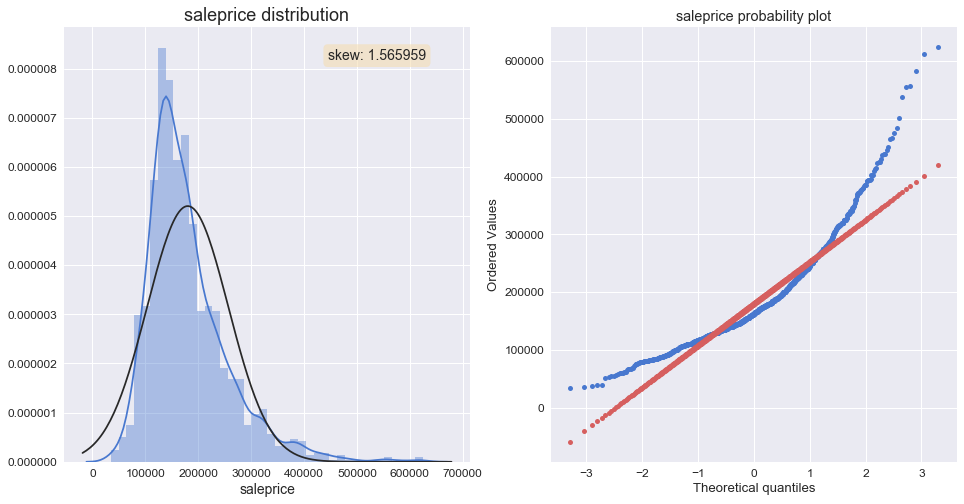

NormaltestResult(statistic=460.3067960010808, pvalue=1.1108342380647651e-100)


In [62]:
plt.figure(figsize=(16,8))

ax1 = plt.subplot(121)
sns.distplot(train['saleprice'], ax=ax1, fit=norm)
ax1.set_xlabel('saleprice', size=14)
ax1.set_title('saleprice distribution', size=18)
#text box
props = dict(boxstyle='round', color='wheat', alpha=.6)
textstr1 = 'skew: %f' % (train['saleprice'].skew())
ax1.text(0.65, 0.95, textstr1, transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax2 = plt.subplot(122)
stats.probplot(train['saleprice'], plot=ax2)
ax2.set_title('saleprice probability plot')
ax2.get_lines()[0].set_marker('.')
ax2.get_lines()[0].set_markerfacecolor(color_b)
ax2.get_lines()[0].set_markersize(10)
ax2.get_lines()[1].set_linewidth(0)
ax2.get_lines()[1].set_marker('.')
ax2.get_lines()[1].set_markerfacecolor(color_r)
ax2.get_lines()[1].set_markersize(10)

plt.show()
print(stats.normaltest(a=train['saleprice']))

- 'saleprice' is not normally distributed
- See how log transformation looks

In [63]:
print('log:', stats.normaltest(a=np.log(train['saleprice'])))
print('log1p:', stats.normaltest(a=np.log1p(train['saleprice'])))

log: NormaltestResult(statistic=17.417871145375766, pvalue=0.0001651039020773473)
log1p: NormaltestResult(statistic=17.41764459169927, pvalue=0.00016512260558467428)


- Log transforming saleprice results in a much more normal distribution
- Log & log1p methods produce nearly identical resuls
- Prefer log1p since it avoids producing problematic '-inf' values (result of trying to log zero or negative)

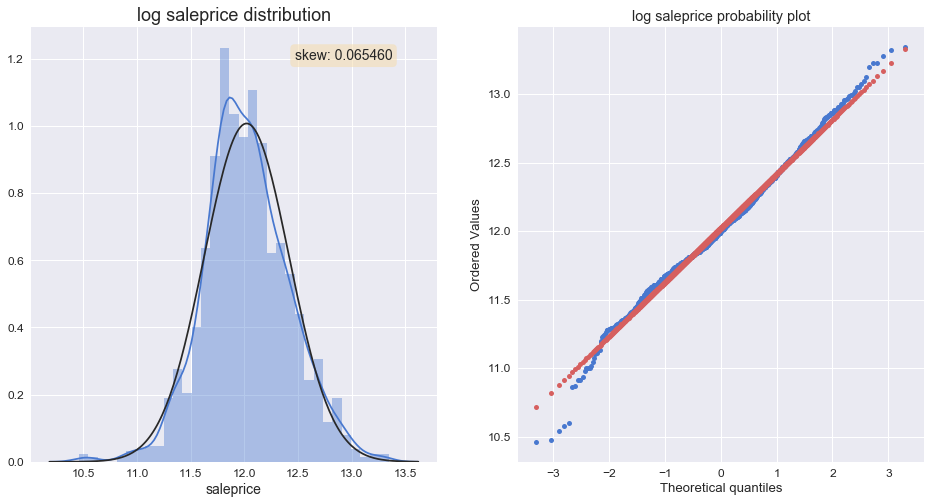

NormaltestResult(statistic=17.41764459169927, pvalue=0.00016512260558467428)


In [64]:
train['saleprice'] = np.log1p(train['saleprice'])

plt.figure(figsize=(16,8))

ax1 = plt.subplot(121)
sns.distplot(train['saleprice'], ax=ax1, fit=norm)
ax1.set_xlabel('saleprice', size=14)
ax1.set_title('log saleprice distribution', size=18)
#text box
props = dict(boxstyle='round', color='wheat', alpha=.6)
textstr1 = 'skew: %f' % (train['saleprice'].skew())
ax1.text(0.65, 0.95, textstr1, transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax2 = plt.subplot(122)
stats.probplot(train['saleprice'], plot=ax2)
ax2.set_title('log saleprice probability plot')
ax2.get_lines()[0].set_marker('.')
ax2.get_lines()[0].set_markerfacecolor(color_b)
ax2.get_lines()[0].set_markersize(10)
ax2.get_lines()[1].set_linewidth(0)
ax2.get_lines()[1].set_marker('.')
ax2.get_lines()[1].set_markerfacecolor(color_r)
ax2.get_lines()[1].set_markersize(10)

plt.show()
print(stats.normaltest(a=train['saleprice']))

#at this point can set y
#don't need the train df iv's anymore, all in the full iv df
y = train['saleprice']

### 2.4/2.5 Independent Variables, Feature Engineering/Selection
Looking through the data_description.txt file reveals a few issues
1. Categorical variables with numeric data
2. Month & year variables are separate:
    - Month sold could point to seasonal sale trends
    - Year sold could show broader economic real estate market trends
    - Lacking a chronologic variable that combines the two: create this feature
3. 'Yearbuilt' variable:
    - Valuable information to buyers because it provides an age for the house
    - This data has no data explicitly containing this information, but does have year of sale data
    - Create an age when sold feature to more accurately capture house age affect on sale price
4. Many ordinal variables: need to decide how to treat these
    - Leave as categorical data, create dummies
    - Treat as continuous, recode scale to numeric

In [65]:
#recode numeric data that should be categorical
df = df.replace(
    {'mssubclass':{20:'subclasss20', 30:'subclass30', 40:'subclass40',
                   45:'subclass45', 50:'subclass50', 60:'subclass60',
                   70:'subclass70', 75:'subclass75', 80:'subclass80',
                   85:'subclass85', 90:'subclass90', 120:'subclass120',
                   150:'subclass150', 160:'subclass160', 180:'subclass180',
                   190:'subclass190'},
     'mosold':{1:'_01jan', 2:'_02feb', 3:'_03mar', 4:'_04apr', 5:'_05may',
               6:'_06jun', 7:'_07jul', 8:'_08aug', 9:'_09sep', 10:'_10oct',
               11:'_11nov', 12:'_12dec'}})

#create year & month sold feature
df['yrmo_sold'] = df.yrsold.astype(
    str).str.cat(df.mosold.astype(str))

#create age of house at sale feature
df['age_at_sale'] = df['yrsold'] - df['yearbuilt']

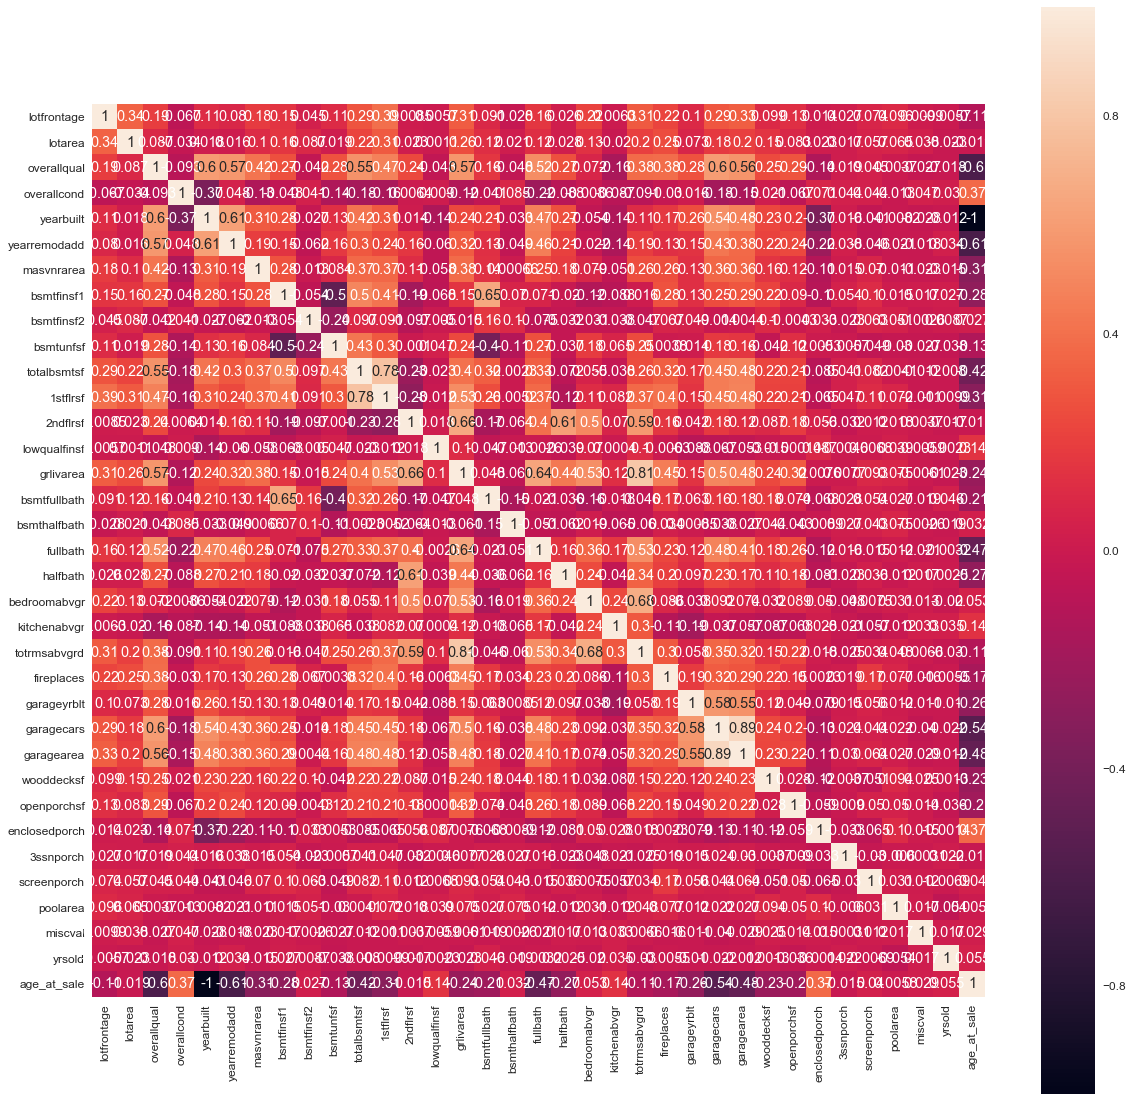

In [66]:
#check iv collinearity
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), square=True, annot=True)
plt.show()

#### Collinearity to address
1. garagecars & garagearea
    - Convey basically the same information
    - Garagecars is more intuitive and more highly correlated with saleprice
    - Drop garagearea, keep garagecars
2. square footage and room count variables
    - SF variables overall are more highly correlated with 'saleprice'
    - Keep SF variables, drop room count variables
3. lotfrontage & lotarea
    - A fair amount of lotfrontage was imputed based on lotarea
    - Neither is very highly correlated with sale price
    - Scale & average together

In [67]:
#drops
df = df.loc[:, ~(df.columns).isin(
    ['garagearea','bsmtfullbath', 'bsmthalfbath','fullbath',
     'halfbath', 'bedroomabvgr','kitchenabvgr', 'totrmsabvgrd']
)]
#lot feature
means = df[['lotarea', 'lotfrontage']].mean(axis=0)
stds = df[['lotarea', 'lotfrontage']].std(axis=0)
lot_feature = ((df[['lotarea', 'lotfrontage']] - means) / stds).mean(axis=1)

df['lot_feature'] = lot_feature
df = df.loc[:, ~(df.columns).isin(['lotarea', 'lotfrontage'])]

# 3 Modeling


## Categorical Ordinal Data
- Need to change the 2 ordinal variables that are represented numerically in the data

In [68]:
ord_cat = df.copy()
ord_cat = ord_cat.replace({
    'overallqual':{1:'Very Poor', 2:'Poor', 3:'Fair', 4:'Below Average',
                   5:'Average', 6:'Above Average', 7:'Good', 8:'Very Good',
                   9:'Excellent', 10:'Very Excellent'},
    'overallcond':{1:'Very Poor', 2:'Poor', 3:'Fair', 4:'Below Average',
                   5:'Average', 6:'Above Average', 7:'Good', 8:'Very Good',
                   9:'Excellent', 10:'Very Excellent'}
})

In [69]:
#get dummies and set data
ord_cat = pd.get_dummies(ord_cat)
X = ord_cat[:train.shape[0]]

#evaluation function
def rmse(model):
    rmse = np.sqrt(-cross_val_score(
        model, X, y, cv=5, scoring='neg_mean_squared_error'))
    return(rmse)

### Ridge

alpha broad search: 10.0
1st cv rmse score mean: 0.11808532893784127

alpha tuned: 7.5
2nd cv rmse score mean: 0.11798829931967295

total runtime: 2.6 seconds


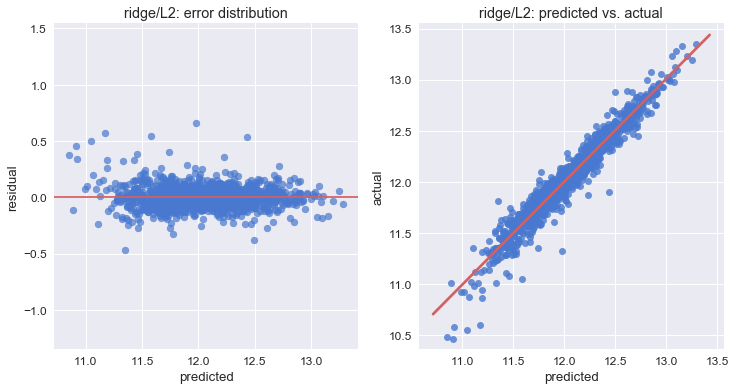

In [70]:
start_time = time.clock()
#broad alpha search
ridge = RidgeCV(
    alphas=[0.1, 0.5, 1, 5, 10]
).fit(X, y)
alpha = ridge.alpha_
print('alpha broad search:', alpha)
print('1st cv rmse score mean:', rmse(ridge).mean())

#fine alpha search
ridge = RidgeCV(
    alphas=[alpha, alpha*0.25, alpha*0.5, alpha*0.75,
            alpha*1.25, alpha*1.5, alpha*1.75, alpha*2]
).fit(X, y)
print('\nalpha tuned:', ridge.alpha_)
print('2nd cv rmse score mean:', rmse(ridge).mean())
print('\ntotal runtime: {} seconds'.format(round((time.clock()-start_time),2)))

#plot results
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
plt.scatter(ridge.predict(X), ridge.predict(X) - y, alpha=0.7)
plt.axhline(y=0, color=color_r)
plt.axis('equal')
plt.xlabel('predicted')
plt.ylabel('residual')
plt.title('ridge/L2: error distribution')

ax2 = plt.subplot(122)
sns.regplot(ridge.predict(X), y, ax=ax2, line_kws={'color':color_r})
plt.axis('equal')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('ridge/L2: predicted vs. actual')
plt.show()

### Lasso

alpha broad search: 0.0005
1st cv rmse score mean: 0.11477227900576473

alpha tuned: 0.000375
2nd cv rmse score mean: 0.11493380914914837

total runtime: 16.62 seconds


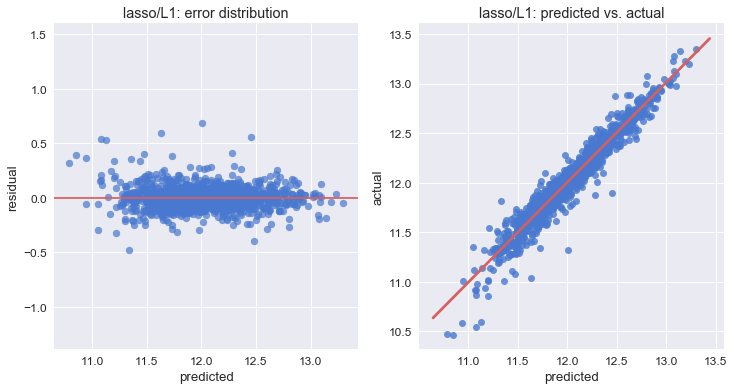

In [71]:
start_time = time.clock()
#broad alpha search
lasso = LassoCV(
    alphas=[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5,1, 5]
).fit(X, y)
alpha = lasso.alpha_
print('alpha broad search:', alpha)
print('1st cv rmse score mean:', rmse(lasso).mean())

#fine alpha search
lasso = LassoCV(
    alphas=[alpha, alpha*0.25, alpha*0.5, alpha*0.75,
            alpha*1.25, alpha*1.5, alpha*1.75, alpha*2]
).fit(X, y)
print('\nalpha tuned:', lasso.alpha_)
print('2nd cv rmse score mean:', rmse(lasso).mean())
print('\ntotal runtime: {} seconds'.format(round((time.clock()-start_time),2)))

#plot results
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
plt.scatter(lasso.predict(X), lasso.predict(X) - y, alpha=0.7)
plt.axhline(y=0, color=color_r)
plt.axis('equal')
plt.xlabel('predicted')
plt.ylabel('residual')
plt.title('lasso/L1: error distribution')

ax2 = plt.subplot(122)
sns.regplot(lasso.predict(X), y, ax=ax2, line_kws={'color':color_r})
plt.axis('equal')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('lasso/L1: predicted vs. actual')
plt.show()

### Elastic Net

l1 ratio broad search:  0.7
alpha broad search:  0.0006
1st cv rmse score mean:  0.11482074434717138

l1 ratio tuned:  0.95
alpha tuned:  0.0004
2nd cv rmse score mean: 0.11471250264692853

total runtime: 124.93 seconds


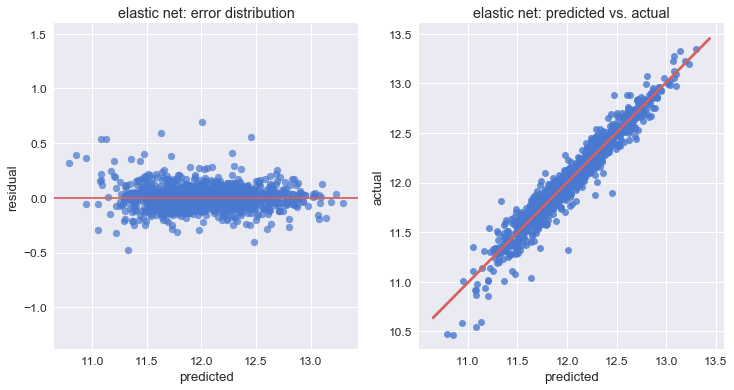

In [72]:
start_time = time.clock()
#broad param search
el_net = ElasticNetCV(
    l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
    alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
            0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6],
    cv=5
).fit(X,y)
print('l1 ratio broad search: ', el_net.l1_ratio_)
print('alpha broad search: ', el_net.alpha_)
print('1st cv rmse score mean: ', rmse(el_net).mean())

#fine param search
el_net = ElasticNetCV(l1_ratio=[0.9, 0.85, 0.8, 0.95],
                      alphas=[0.0006, 0.0005,0.0004, 0.0007, 0.0008], cv=5
                     ).fit(X,y)
print('\nl1 ratio tuned: ', el_net.l1_ratio_)
print('alpha tuned: ', el_net.alpha_)
print('2nd cv rmse score mean:', rmse(el_net).mean())
print('\ntotal runtime: {} seconds'.format(round((time.clock()-start_time),2)))

#plot results
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
plt.scatter(el_net.predict(X), el_net.predict(X) - y, alpha=0.7)
plt.axhline(y=0, color=color_r)
plt.axis('equal')
plt.xlabel('predicted')
plt.ylabel('residual')
plt.title('elastic net: error distribution')

ax2 = plt.subplot(122)
sns.regplot(el_net.predict(X), y, ax=ax2, line_kws={'color':color_r})
plt.axis('equal')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('elastic net: predicted vs. actual')
plt.show()

### Random Forest

In [73]:
start_time = time.clock()
rfr = ensemble.RandomForestRegressor()
params = [{'n_estimators':[10, 50, 100, 250, 500],
           'max_features':[1, int(len(X.columns)), len(X.columns)],
           'max_depth':[10,20,30,40]}]

grid = GridSearchCV(
    estimator=rfr,
    param_grid=params,
    scoring='neg_mean_squared_error'
).fit(X,y)
print('params:', grid.best_params_)

rfr = ensemble.RandomForestRegressor(
    n_estimators=grid.best_params_.get('n_estimators'),
    max_depth=grid.best_params_.get('max_depth'),
    max_features=grid.best_params_.get('max_features')
).fit(X, y)
print('cv rmse score mean:', rmse(rfr).mean())
print('total runtime: {} seconds'.format(round((time.clock()-start_time),2)))

params: {'max_depth': 30, 'max_features': 392, 'n_estimators': 500}
cv rmse score mean: 0.1411439228034612
total runtime: 555.84 seconds


### XGBoost

In [74]:
start_time = time.clock()
xgbr = XGBRegressor()
params = [{'booster':['gbtree', 'gblinear'],
           'max_depth':[2, 3, 5, 10],
           'learning_rate':[0.1, 0.05, 0.01],
           'subsample':[0.25, 0.5, 0.75, 1]}]

grid = GridSearchCV(
    estimator=xgbr,
    param_grid=params,
    scoring='neg_mean_squared_error'
).fit(X,y)
print('params:', grid.best_params_)

xgbr = XGBRegressor(
    booster=grid.best_params_.get('booster'),
    max_depth=grid.best_params_.get('max_depth'),
    learning_rate=grid.best_params_.get('learning_rate'),
    subsample=grid.best_params_.get('subsample')
).fit(X, y)
print('cv rmse score mean:', rmse(xgbr).mean())
print('runtime: ', time.clock() - start_time)

params: {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.75}
cv rmse score mean: 0.12976784142630554
runtime:  195.299485


## Continuous Ordinal Data

In [75]:
ord_cont = df.copy()
ord_cont = ord_cont.replace(
    {'lotshape':{'IR3':1, 'IR2':2, 'IR1':3, 'Reg':4},
     'utilities':{'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4},
     'landslope':{'Gtl':1, 'Mod':2, 'Sev':3},
     'exterqual':{'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'extercond':{'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'bsmtqual':{'none':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'bsmtcond':{'none':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'bsmtexposure':{'none':0, 'No':0, 'Mn':2, 'Av':3, 'Gd':4},
     'bsmtfintype1':{'none':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4,
                     'ALQ':5, 'GLQ':6},
     'bsmtfintype2':{'none':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 
                     'ALQ':5, 'GLQ':6},
     'heatingqc':{'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'electrical':{'Mix':0, 'FuseP':1, 'FuseF':2, 'FuseA':3, 'SBrkr':4},
     'kitchenqual':{'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'functional':{'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5,
                   'Min2':6, 'Min1':7, 'Typ':8},
     'fireplacequ':{'none':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'garagefinish':{'none':0, 'Unf':1, 'RFn':2, 'Fin':3},
     'garagequal':{'none':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'garagecond':{'none':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'paveddrive':{'N':1, 'P':2, 'Y':2},
     'poolqc':{'none':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4},
     'fence':{'none':0, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4}}
)

In [76]:
cat_vars = ord_cont.dtypes[ord_cont.dtypes == 'object'].index.tolist()
ord_vars = ['overallqual', 'overallcond', 'lotshape', 'utilities',
            'landslope', 'exterqual', 'extercond', 'bsmtqual', 'bsmtcond',
            'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heatingqc',
            'electrical','kitchenqual', 'functional', 'fireplacequ',
            'garagefinish', 'garagequal', 'garagecond', 'paveddrive',
            'poolqc', 'fence']
cont_vars = ord_cont.dtypes[ord_cont.dtypes != 'object'].index.tolist()
cont_vars = [x for x in cont_vars if x not in ord_vars]

#### Collinearity of new continuous data

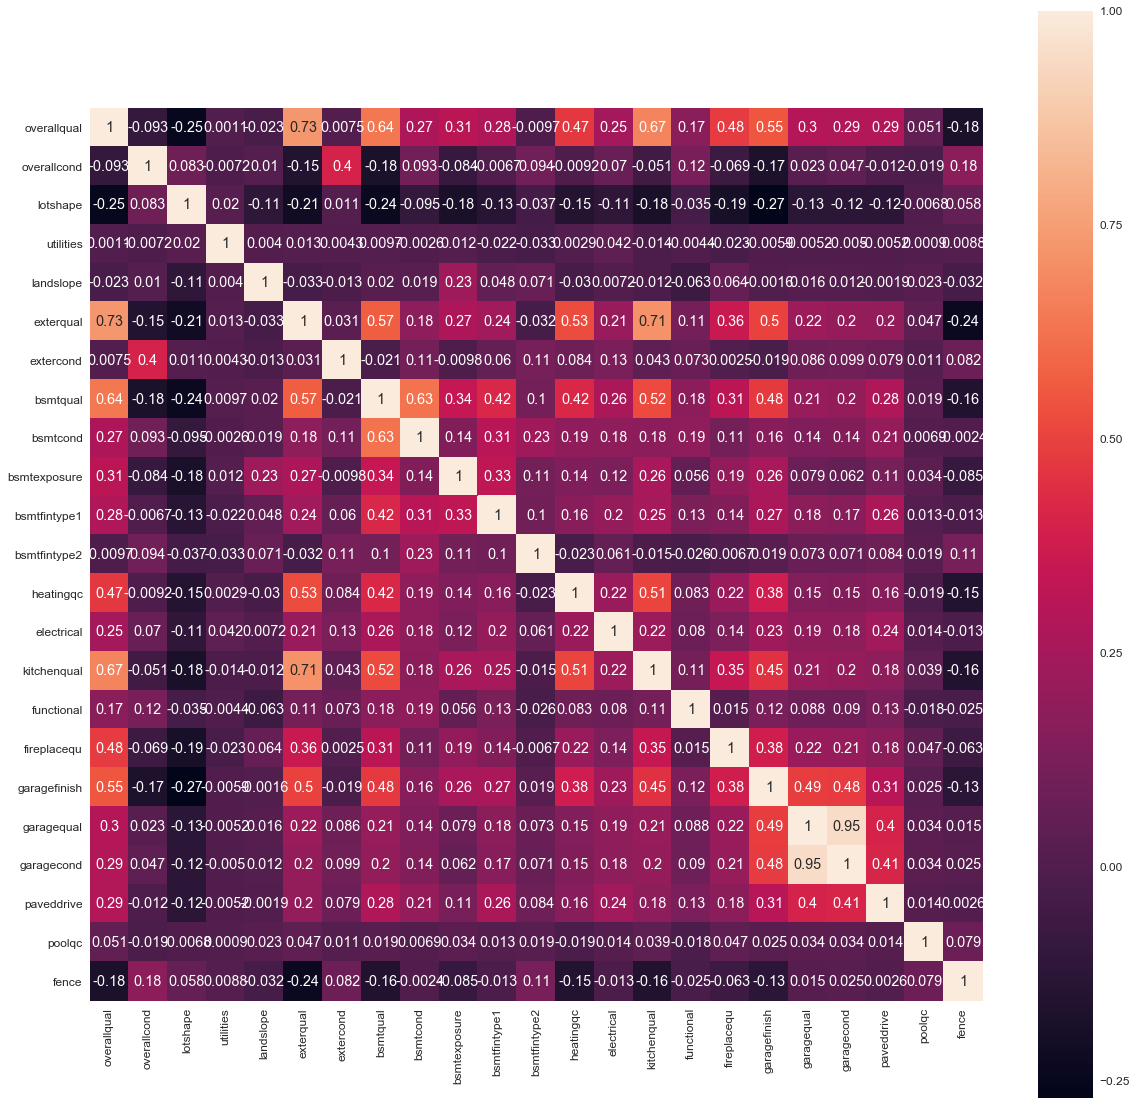

In [77]:
plt.figure(figsize=(20,20))
sns.heatmap(ord_cont[ord_vars].corr(), square=True, annot=True)
plt.show()

#### Collinearity issues
Opportunity to create a few principle components
- garagefinish, garagequal, garagecond
- bsmtqual, bsmtcond
- exterqual, heatingqc, kitchenqual

In [78]:
#new df to populate with training data
df_pca = pd.DataFrame(ord_cont[cat_vars])

In [79]:
#garage principle component
garage_df = ord_cont[['garagefinish', 'garagequal', 'garagecond']]
garage_std = StandardScaler().fit_transform(garage_df)
garage_pc = PCA(n_components=1).fit_transform(garage_std)
df_pca['garage_pc'] = garage_pc

#basement prin comp
bsmt_df = ord_cont[['bsmtqual', 'bsmtcond']]
bsmt_std = StandardScaler().fit_transform(bsmt_df)
bsmt_pc = PCA(n_components=1).fit_transform(bsmt_std)
df_pca['bsmt_pc'] = bsmt_pc

#quality prin comp
qual_df = ord_cont[['exterqual', 'heatingqc', 'kitchenqual']]
qual_std = StandardScaler().fit_transform(qual_df)
qual_pc = PCA(n_components=1).fit_transform(qual_std)
df_pca['qual_pc'] = qual_pc

In [80]:
#add untouched ordinal vars
pca_ord_vars = ['garagetype', 'garagefinish', 'garagequal', 'garagecond',
                'bsmtqual', 'bsmtcond', 'exterqual', 'heatingqc',
                'kitchenqual']
ords_to_add = [x for x in ord_vars if x not in pca_ord_vars]
df_pca[ords_to_add] = ord_cont[ords_to_add]

#add original cont vars
df_pca[cont_vars] = ord_cont[cont_vars]

#check on df
df_pca.head()

,mssubclass,mszoning,street,alley,landcontour,lotconfig,neighborhood,condition1,condition2,bldgtype,...,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,yrsold,age_at_sale,lot_feature
0,subclass60,RL,Pave,none,Lvl,Inside,CollgCr,Norm,Norm,1Fam,...,0,61,0,0,0,0,0,2008,5,-0.206538
1,subclasss20,RL,Pave,none,Lvl,FR2,Veenker,Feedr,Norm,1Fam,...,298,0,0,0,0,0,0,2007,31,0.229436
2,subclass60,RL,Pave,none,Lvl,Inside,CollgCr,Norm,Norm,1Fam,...,0,42,0,0,0,0,0,2008,7,0.045637
3,subclass70,RL,Pave,none,Lvl,Corner,Crawfor,Norm,Norm,1Fam,...,0,35,272,0,0,0,0,2006,91,-0.256640
4,subclass60,RL,Pave,none,Lvl,FR2,NoRidge,Norm,Norm,1Fam,...,192,84,0,0,0,0,0,2008,8,0.625155


## Model with continuous ordinal data

In [81]:
#dummies & data
ord_cont = pd.get_dummies(ord_cont)
X = ord_cont[:train.shape[0]]

#evaluation function
def rmse(model):
    rmse = np.sqrt(-cross_val_score(
        model, X, y, cv=5, scoring='neg_mean_squared_error'))
    return(rmse)

### Ridge

alpha broad search: 10.0
1st cv rmse score mean: 0.11396265557063404

alpha tuned: 17.5
2nd cv rmse score mean: 0.11381298758404249

total runtime: 1.36 seconds


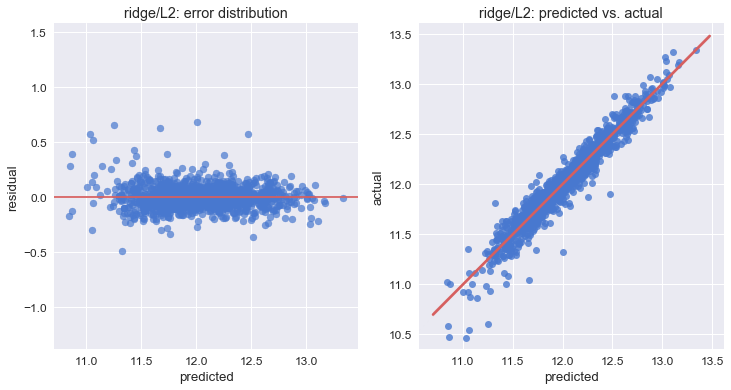

In [82]:
start_time = time.clock()
#broad alpha search
ridge = RidgeCV(
    alphas=[0.1, 0.5, 1, 5, 10]
).fit(X, y)
alpha = ridge.alpha_
print('alpha broad search:', alpha)
print('1st cv rmse score mean:', rmse(ridge).mean())

#fine alpha search
ridge = RidgeCV(
    alphas=[alpha, alpha*0.25, alpha*0.5, alpha*0.75,
            alpha*1.25, alpha*1.5, alpha*1.75, alpha*2]
).fit(X, y)
print('\nalpha tuned:', ridge.alpha_)
print('2nd cv rmse score mean:', rmse(ridge).mean())
print('\ntotal runtime: {} seconds'.format(round((time.clock()-start_time),2)))

#plot results
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
plt.scatter(ridge.predict(X), ridge.predict(X) - y, alpha=0.7)
plt.axhline(y=0, color=color_r)
plt.axis('equal')
plt.xlabel('predicted')
plt.ylabel('residual')
plt.title('ridge/L2: error distribution')

ax2 = plt.subplot(122)
sns.regplot(ridge.predict(X), y, ax=ax2, line_kws={'color':color_r})
plt.axis('equal')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('ridge/L2: predicted vs. actual')
plt.show()

### Lasso

alpha broad search: 0.0005
1st cv rmse score mean: 0.11052414078710895

alpha tuned: 0.0005
2nd cv rmse score mean: 0.11061853170758451

total runtime: 9.44 seconds


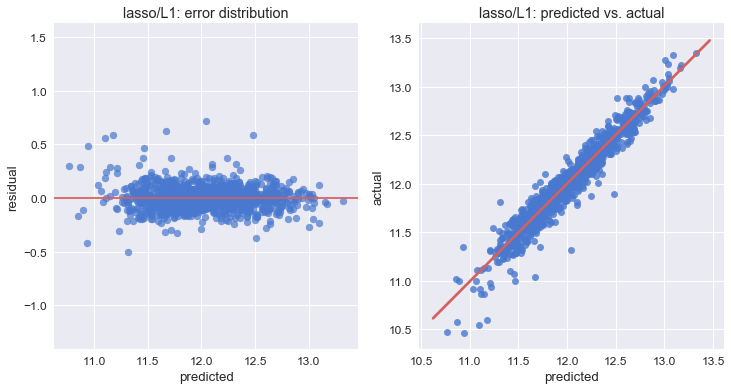

In [83]:
start_time = time.clock()
#broad alpha search
lasso = LassoCV(
    alphas=[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5,1, 5]
).fit(X, y)
alpha = lasso.alpha_
print('alpha broad search:', alpha)
print('1st cv rmse score mean:', rmse(lasso).mean())

#fine alpha search
lasso = LassoCV(
    alphas=[alpha, alpha*0.25, alpha*0.5, alpha*0.75,
            alpha*1.25, alpha*1.5, alpha*1.75, alpha*2]
).fit(X, y)
print('\nalpha tuned:', lasso.alpha_)
print('2nd cv rmse score mean:', rmse(lasso).mean())
print('\ntotal runtime: {} seconds'.format(round((time.clock()-start_time),2)))

#plot results
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
plt.scatter(lasso.predict(X), lasso.predict(X) - y, alpha=0.7)
plt.axhline(y=0, color=color_r)
plt.axis('equal')
plt.xlabel('predicted')
plt.ylabel('residual')
plt.title('lasso/L1: error distribution')

ax2 = plt.subplot(122)
sns.regplot(lasso.predict(X), y, ax=ax2, line_kws={'color':color_r})
plt.axis('equal')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('lasso/L1: predicted vs. actual')
plt.show()

### Elastic Net

l1 ratio broad search:  0.9
alpha broad search:  0.0006
1st cv rmse score mean:  0.11074299814416791

l1 ratio tuned:  0.95
alpha tuned:  0.0005
2nd cv rmse score mean: 0.11055610976909888

total runtime: 65.33 seconds


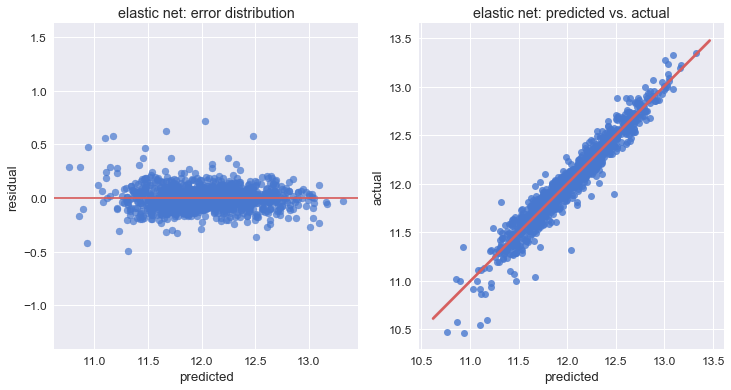

In [84]:
start_time = time.clock()
#broad param search
el_net = ElasticNetCV(
    l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
    alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
            0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6],
    cv=5
).fit(X,y)
print('l1 ratio broad search: ', el_net.l1_ratio_)
print('alpha broad search: ', el_net.alpha_)
print('1st cv rmse score mean: ', rmse(el_net).mean())

#fine param search
el_net = ElasticNetCV(l1_ratio=[0.9, 0.85, 0.8, 0.95],
                      alphas=[0.0006, 0.0005,0.0004, 0.0007, 0.0008], cv=5
                     ).fit(X,y)
print('\nl1 ratio tuned: ', el_net.l1_ratio_)
print('alpha tuned: ', el_net.alpha_)
print('2nd cv rmse score mean:', rmse(el_net).mean())
print('\ntotal runtime: {} seconds'.format(round((time.clock()-start_time),2)))

#plot results
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
plt.scatter(el_net.predict(X), el_net.predict(X) - y, alpha=0.7)
plt.axhline(y=0, color=color_r)
plt.axis('equal')
plt.xlabel('predicted')
plt.ylabel('residual')
plt.title('elastic net: error distribution')

ax2 = plt.subplot(122)
sns.regplot(el_net.predict(X), y, ax=ax2, line_kws={'color':color_r})
plt.axis('equal')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('elastic net: predicted vs. actual')
plt.show()

### Random Forest

In [85]:
start_time = time.clock()
rfr = ensemble.RandomForestRegressor()
params = [{'n_estimators':[10, 50, 100, 250, 500],
           'max_features':[1, int(len(X.columns)), len(X.columns)],
           'max_depth':[10,20,30,40]}]

grid = GridSearchCV(
    estimator=rfr,
    param_grid=params,
    scoring='neg_mean_squared_error'
).fit(X,y)
print('params:', grid.best_params_)

rfr = ensemble.RandomForestRegressor(
    n_estimators=grid.best_params_.get('n_estimators'),
    max_depth=grid.best_params_.get('max_depth'),
    max_features=grid.best_params_.get('max_features')
).fit(X, y)
print('cv rmse score mean:', rmse(rfr).mean())
print('total runtime: {} seconds'.format(round((time.clock()-start_time),2)))

params: {'max_depth': 40, 'max_features': 294, 'n_estimators': 500}
cv rmse score mean: 0.1365206063321614
total runtime: 416.02 seconds


### XGBoost

In [86]:
start_time = time.clock()
xgbr = XGBRegressor()
params = [{'booster':['gbtree', 'gblinear'],
           'max_depth':[2, 3, 5, 10],
           'learning_rate':[0.1, 0.05, 0.01],
           'subsample':[0.25, 0.5, 0.75, 1]}]

grid = GridSearchCV(
    estimator=xgbr,
    param_grid=params,
    scoring='neg_mean_squared_error'
).fit(X,y)
print('params:', grid.best_params_)

xgbr = XGBRegressor(
    booster=grid.best_params_.get('booster'),
    max_depth=grid.best_params_.get('max_depth'),
    learning_rate=grid.best_params_.get('learning_rate'),
    subsample=grid.best_params_.get('subsample')
).fit(X, y)
print('cv rmse score mean:', rmse(xgbr).mean())
print('runtime: ', time.clock() - start_time)

params: {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.75}
cv rmse score mean: 0.12048780725327382
runtime:  148.076409


## Mixed Ordinal Data
Manually select which ordinal variables to represent with categorical data and which to represent with numerical data.

Categorical: clearly defined categories that don't really have much 'range'
Continuous: categories where possible values are more of a spectrum

In [87]:
ord_mix = df.copy()
cat_vars = ord_mix.dtypes[ord_mix.dtypes == 'object'].index.tolist()
ord_vars = ['overallqual', 'overallcond', 'lotshape', 'utilities',
            'landslope', 'exterqual', 'extercond', 'bsmtqual', 'bsmtcond',
            'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heatingqc',
            'electrical','kitchenqual', 'functional', 'fireplacequ',
            'garagefinish', 'garagequal', 'garagecond', 'paveddrive',
            'poolqc', 'fence']
cont_vars = ord_mix.dtypes[ord_mix.dtypes != 'object'].index.tolist()
cont_vars = [x for x in cont_vars if x not in ord_vars]

#Categorical Ordinal Variables
ord_cat = ['utilities', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'electrical',
           'functional', 'fireplacequ', 'garagefinish', 'paveddrive', 'fence']

#Continuous Ordinal Variables
ord_cont = ['overallqual', 'overallcond', 'lotshape', 'landslope',
            'exterqual', 'extercond', 'bsmtfintype1', 'bsmtfintype2',
            'heatingqc', 'kitchenqual', 'garagequal', 'garagecond', 'poolqc']

#Make sure that's all of them
print(len(ord_vars) == (len(ord_cat) + len(ord_cont)))

True


In [88]:
#recode ordinal categorical data as numeric
#overallqual and overallcond already numeric
ord_mix = ord_mix.replace(
    {'lotshape':{'IR3':1, 'IR2':2, 'IR1':3, 'Reg':4},
     'landslope':{'Gtl':1, 'Mod':2, 'Sev':3},
     'exterqual':{'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'extercond':{'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'bsmtfintype1':{'none':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4,
                     'ALQ':5, 'GLQ':6},
     'bsmtfintype2':{'none':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 
                     'ALQ':5, 'GLQ':6},
     'heatingqc':{'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'kitchenqual':{'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'garagequal':{'none':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'garagecond':{'none':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'poolqc':{'none':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4},}
)

#### Collinearity check

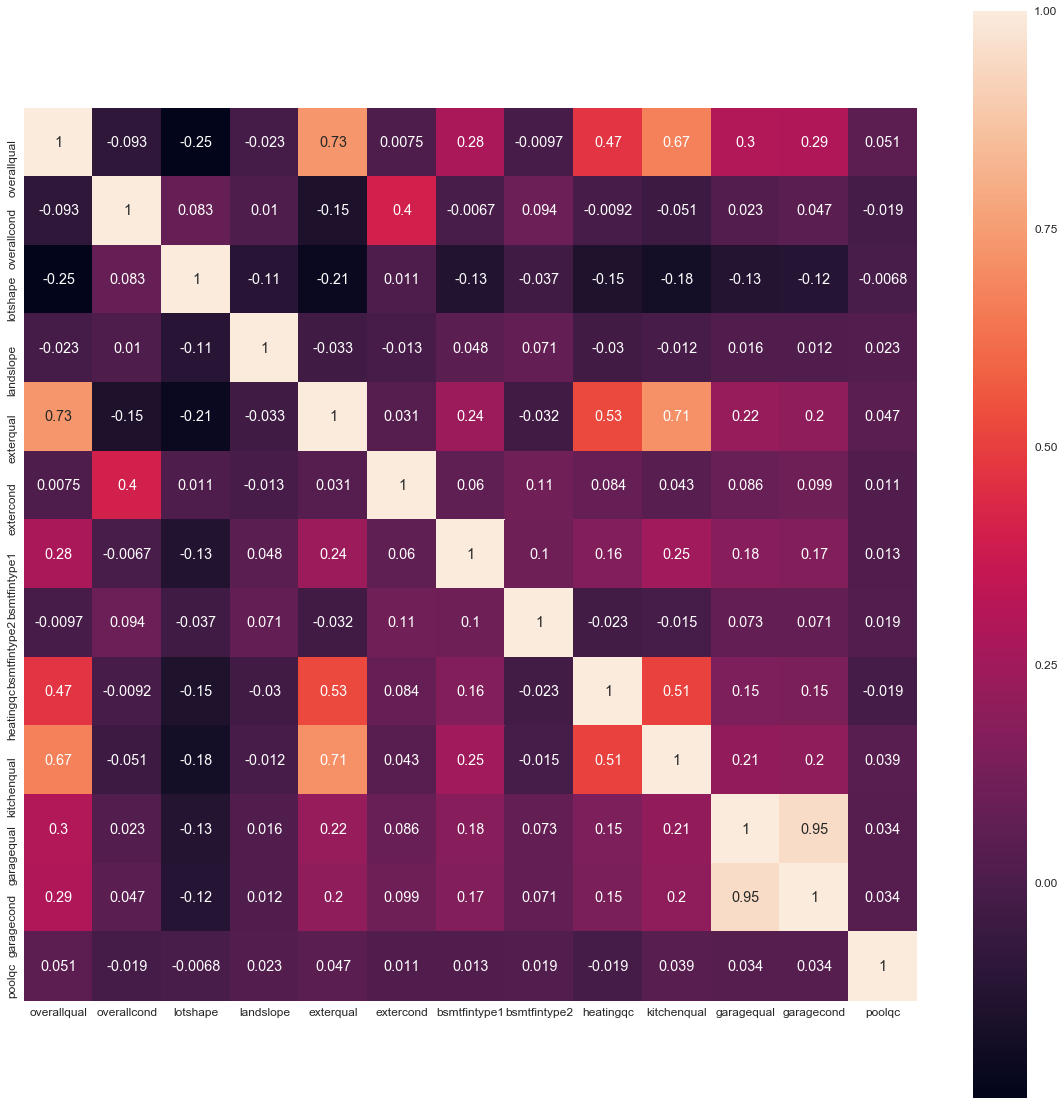

In [89]:
plt.figure(figsize=(20,20))
sns.heatmap(ord_mix[ord_cont].corr(), square=True, annot=True)
plt.show()

#### Features/PCA

In [90]:
#garage prin comp
garage_df = ord_mix[['garagequal', 'garagecond']]
garage_std = StandardScaler().fit_transform(garage_df)
garage_pc = PCA(n_components=1).fit_transform(garage_std)
ord_mix = ord_mix.loc[:, ~(ord_mix.columns).isin(['garagequal', 'garagecond'])]
ord_mix['garage_pc'] = garage_pc

#quality prin comp
qual_df = ord_mix[['exterqual', 'heatingqc', 'kitchenqual']]
qual_std = StandardScaler().fit_transform(qual_df)
qual_pc = PCA(n_components=1).fit_transform(qual_std)
ord_mix = ord_mix.loc[:, ~(ord_mix.columns).isin(['exterqual', 'heatingqc', 'kitchenqual'])]
ord_mix['qual_pc'] = qual_pc

## Model with mixed ordinal data

In [91]:
#dummies & data
ord_mix = pd.get_dummies(ord_mix)
X = ord_mix[:train.shape[0]]

#evaluation function
def rmse(model):
    rmse = np.sqrt(-cross_val_score(
        model, X, y, cv=5, scoring='neg_mean_squared_error'))
    return(rmse)

### Ridge

alpha broad search: 10.0
1st cv rmse score mean: 0.11482489846045332

alpha tuned: 17.5
2nd cv rmse score mean: 0.1145477952866886

total runtime: 1.63 seconds


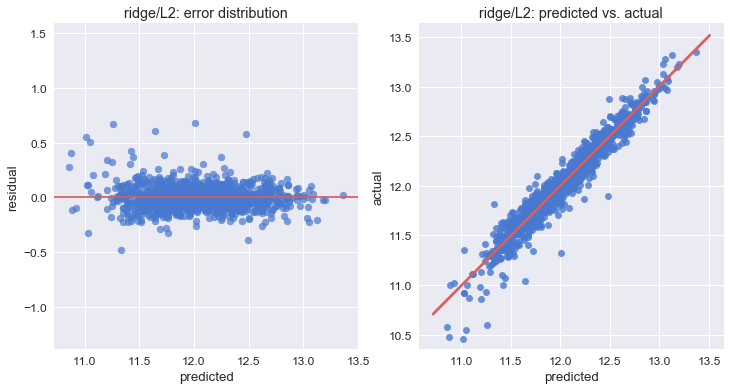

In [92]:
start_time = time.clock()
#broad alpha search
ridge = RidgeCV(
    alphas=[0.1, 0.5, 1, 5, 10]
).fit(X, y)
alpha = ridge.alpha_
print('alpha broad search:', alpha)
print('1st cv rmse score mean:', rmse(ridge).mean())

#fine alpha search
ridge = RidgeCV(
    alphas=[alpha, alpha*0.25, alpha*0.5, alpha*0.75,
            alpha*1.25, alpha*1.5, alpha*1.75, alpha*2]
).fit(X, y)
print('\nalpha tuned:', ridge.alpha_)
print('2nd cv rmse score mean:', rmse(ridge).mean())
print('\ntotal runtime: {} seconds'.format(round((time.clock()-start_time),2)))

#plot results
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
plt.scatter(ridge.predict(X), ridge.predict(X) - y, alpha=0.7)
plt.axhline(y=0, color=color_r)
plt.axis('equal')
plt.xlabel('predicted')
plt.ylabel('residual')
plt.title('ridge/L2: error distribution')

ax2 = plt.subplot(122)
sns.regplot(ridge.predict(X), y, ax=ax2, line_kws={'color':color_r})
plt.axis('equal')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('ridge/L2: predicted vs. actual')
plt.show()

### Lasso

alpha broad search: 0.0005
1st cv rmse score mean: 0.11102829788657895

alpha tuned: 0.0005
2nd cv rmse score mean: 0.11137245375357016

total runtime: 10.37 seconds


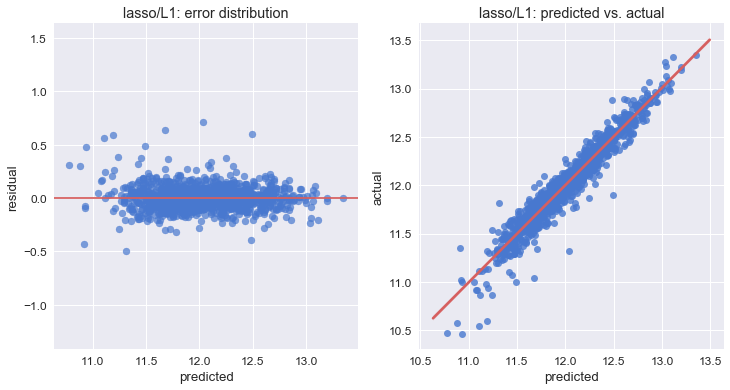

In [93]:
start_time = time.clock()
#broad alpha search
lasso = LassoCV(
    alphas=[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5,1, 5]
).fit(X, y)
alpha = lasso.alpha_
print('alpha broad search:', alpha)
print('1st cv rmse score mean:', rmse(lasso).mean())

#fine alpha search
lasso = LassoCV(
    alphas=[alpha, alpha*0.25, alpha*0.5, alpha*0.75,
            alpha*1.25, alpha*1.5, alpha*1.75, alpha*2]
).fit(X, y)
print('\nalpha tuned:', lasso.alpha_)
print('2nd cv rmse score mean:', rmse(lasso).mean())
print('\ntotal runtime: {} seconds'.format(round((time.clock()-start_time),2)))

#plot results
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
plt.scatter(lasso.predict(X), lasso.predict(X) - y, alpha=0.7)
plt.axhline(y=0, color=color_r)
plt.axis('equal')
plt.xlabel('predicted')
plt.ylabel('residual')
plt.title('lasso/L1: error distribution')

ax2 = plt.subplot(122)
sns.regplot(lasso.predict(X), y, ax=ax2, line_kws={'color':color_r})
plt.axis('equal')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('lasso/L1: predicted vs. actual')
plt.show()

### Elastic Net

l1 ratio broad search:  0.9
alpha broad search:  0.0006
1st cv rmse score mean:  0.11133774595249817

l1 ratio tuned:  0.95
alpha tuned:  0.0005
2nd cv rmse score mean: 0.11117427047403268

total runtime: 72.1 seconds


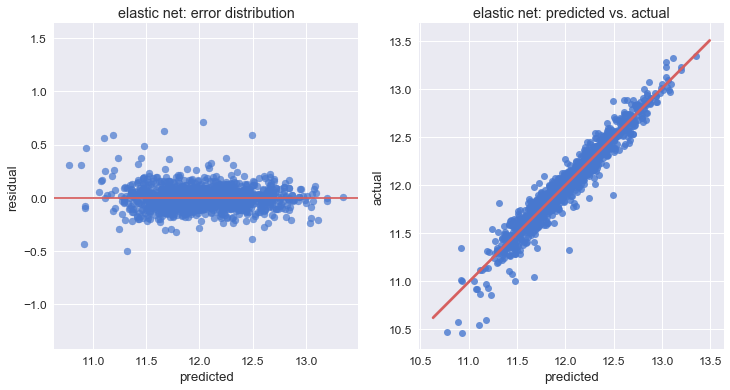

In [94]:
start_time = time.clock()
#broad param search
el_net = ElasticNetCV(
    l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
    alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
            0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6],
    cv=5
).fit(X,y)
print('l1 ratio broad search: ', el_net.l1_ratio_)
print('alpha broad search: ', el_net.alpha_)
print('1st cv rmse score mean: ', rmse(el_net).mean())

#fine param search
el_net = ElasticNetCV(l1_ratio=[0.9, 0.85, 0.8, 0.95],
                      alphas=[0.0006, 0.0005,0.0004, 0.0007, 0.0008], cv=5
                     ).fit(X,y)
print('\nl1 ratio tuned: ', el_net.l1_ratio_)
print('alpha tuned: ', el_net.alpha_)
print('2nd cv rmse score mean:', rmse(el_net).mean())
print('\ntotal runtime: {} seconds'.format(round((time.clock()-start_time),2)))

#plot results
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
plt.scatter(el_net.predict(X), el_net.predict(X) - y, alpha=0.7)
plt.axhline(y=0, color=color_r)
plt.axis('equal')
plt.xlabel('predicted')
plt.ylabel('residual')
plt.title('elastic net: error distribution')

ax2 = plt.subplot(122)
sns.regplot(el_net.predict(X), y, ax=ax2, line_kws={'color':color_r})
plt.axis('equal')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('elastic net: predicted vs. actual')
plt.show()

### Random Forest

In [95]:
start_time = time.clock()
rfr = ensemble.RandomForestRegressor()
params = [{'n_estimators':[10, 50, 100, 250, 500],
           'max_features':[1, int(len(X.columns)), len(X.columns)],
           'max_depth':[10,20,30,40]}]

grid = GridSearchCV(
    estimator=rfr,
    param_grid=params,
    scoring='neg_mean_squared_error'
).fit(X,y)
print('params:', grid.best_params_)

rfr = ensemble.RandomForestRegressor(
    n_estimators=grid.best_params_.get('n_estimators'),
    max_depth=grid.best_params_.get('max_depth'),
    max_features=grid.best_params_.get('max_features')
).fit(X, y)
print('cv rmse score mean:', rmse(rfr).mean())
print('total runtime: {} seconds'.format(round((time.clock()-start_time),2)))

params: {'max_depth': 20, 'max_features': 328, 'n_estimators': 500}
cv rmse score mean: 0.13660525833914414
total runtime: 439.63 seconds


### XGBoost

In [96]:
start_time = time.clock()
xgbr = XGBRegressor()
params = [{'booster':['gbtree', 'gblinear'],
           'max_depth':[2, 3, 5, 10],
           'learning_rate':[0.1, 0.05, 0.01],
           'subsample':[0.25, 0.5, 0.75, 1]}]

grid = GridSearchCV(
    estimator=xgbr,
    param_grid=params,
    scoring='neg_mean_squared_error'
).fit(X,y)
print('params:', grid.best_params_)

xgbr = XGBRegressor(
    booster=grid.best_params_.get('booster'),
    max_depth=grid.best_params_.get('max_depth'),
    learning_rate=grid.best_params_.get('learning_rate'),
    subsample=grid.best_params_.get('subsample')
).fit(X, y)
print('cv rmse score mean:', rmse(xgbr).mean())
print('runtime: ', time.clock() - start_time)

params: {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.5}
cv rmse score mean: 0.11994415133083931
runtime:  162.01950399999987


## Ordinals left alone
Everything is categorical except for overallqual & overallcond which are continuous. Maybe the dataset author was onto something, see how this performs without modifying any ordinal variables from how they were entered into data originally

In [97]:
ord_as_found = df.copy()
#dummies for categoricals
ord_as_found = pd.get_dummies(ord_as_found)
#training data & target
X = ord_as_found[:train.shape[0]]

#evaluation function
def rmse(model):
    rmse = np.sqrt(-cross_val_score(
        model, X, y, cv=5, scoring='neg_mean_squared_error'))
    return(rmse)

### Ridge

alpha broad search: 10.0
1st cv rmse score mean: 0.11467337632767771

alpha tuned: 15.0
2nd cv rmse score mean: 0.11460094312477384

total runtime: 1.87 seconds


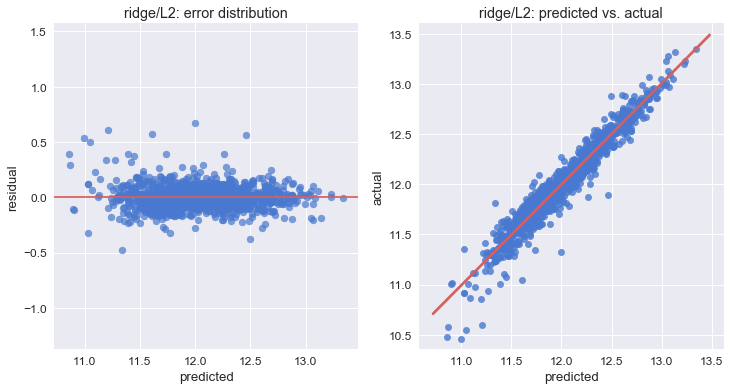

In [98]:
start_time = time.clock()
#broad alpha search
ridge = RidgeCV(
    alphas=[0.1, 0.5, 1, 5, 10]
).fit(X, y)
alpha = ridge.alpha_
print('alpha broad search:', alpha)
print('1st cv rmse score mean:', rmse(ridge).mean())

#fine alpha search
ridge = RidgeCV(
    alphas=[alpha, alpha*0.25, alpha*0.5, alpha*0.75,
            alpha*1.25, alpha*1.5, alpha*1.75, alpha*2]
).fit(X, y)
print('\nalpha tuned:', ridge.alpha_)
print('2nd cv rmse score mean:', rmse(ridge).mean())
print('\ntotal runtime: {} seconds'.format(round((time.clock()-start_time),2)))

#plot results
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
plt.scatter(ridge.predict(X), ridge.predict(X) - y, alpha=0.7)
plt.axhline(y=0, color=color_r)
plt.axis('equal')
plt.xlabel('predicted')
plt.ylabel('residual')
plt.title('ridge/L2: error distribution')

ax2 = plt.subplot(122)
sns.regplot(ridge.predict(X), y, ax=ax2, line_kws={'color':color_r})
plt.axis('equal')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('ridge/L2: predicted vs. actual')
plt.show()

### Lasso

alpha broad search: 0.0005
1st cv rmse score mean: 0.11219144920011578

alpha tuned: 0.0005
2nd cv rmse score mean: 0.11214615089982782

total runtime: 12.31 seconds


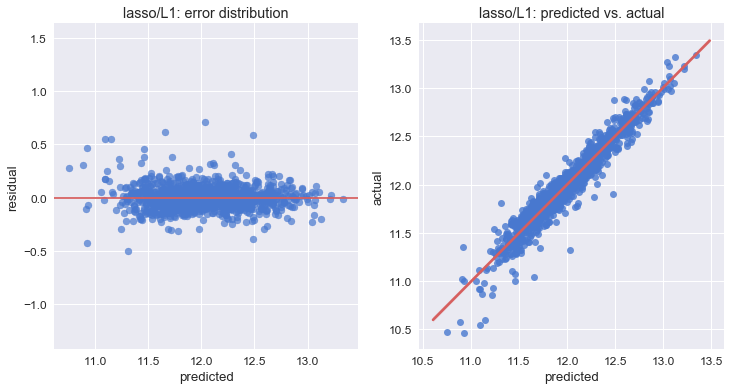

In [99]:
start_time = time.clock()
#broad alpha search
lasso = LassoCV(
    alphas=[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5,1, 5]
).fit(X, y)
alpha = lasso.alpha_
print('alpha broad search:', alpha)
print('1st cv rmse score mean:', rmse(lasso).mean())

#fine alpha search
lasso = LassoCV(
    alphas=[alpha, alpha*0.25, alpha*0.5, alpha*0.75,
            alpha*1.25, alpha*1.5, alpha*1.75, alpha*2]
).fit(X, y)
print('\nalpha tuned:', lasso.alpha_)
print('2nd cv rmse score mean:', rmse(lasso).mean())
print('\ntotal runtime: {} seconds'.format(round((time.clock()-start_time),2)))

#plot results
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
plt.scatter(lasso.predict(X), lasso.predict(X) - y, alpha=0.7)
plt.axhline(y=0, color=color_r)
plt.axis('equal')
plt.xlabel('predicted')
plt.ylabel('residual')
plt.title('lasso/L1: error distribution')

ax2 = plt.subplot(122)
sns.regplot(lasso.predict(X), y, ax=ax2, line_kws={'color':color_r})
plt.axis('equal')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('lasso/L1: predicted vs. actual')
plt.show()

### Elastic Net

l1 ratio broad search:  0.9
alpha broad search:  0.0006
1st cv rmse score mean:  0.11211816983189264

l1 ratio tuned:  0.95
alpha tuned:  0.0005
2nd cv rmse score mean: 0.11209165433319486

total runtime: 89.9 seconds


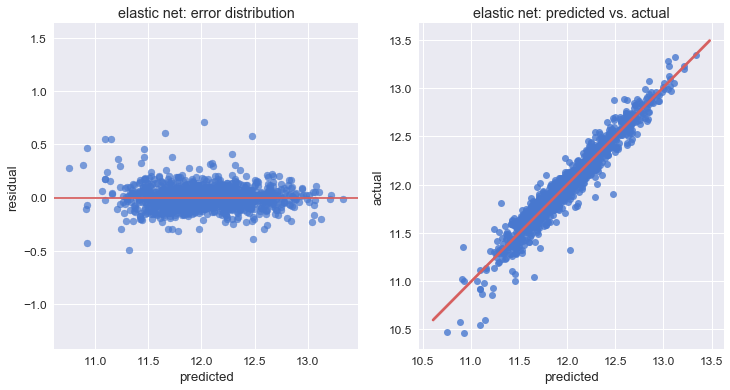

In [100]:
start_time = time.clock()
#broad param search
el_net = ElasticNetCV(
    l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
    alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
            0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6],
    cv=5
).fit(X,y)
print('l1 ratio broad search: ', el_net.l1_ratio_)
print('alpha broad search: ', el_net.alpha_)
print('1st cv rmse score mean: ', rmse(el_net).mean())

#fine param search
el_net = ElasticNetCV(l1_ratio=[0.9, 0.85, 0.8, 0.95],
                      alphas=[0.0006, 0.0005,0.0004, 0.0007, 0.0008], cv=5
                     ).fit(X,y)
print('\nl1 ratio tuned: ', el_net.l1_ratio_)
print('alpha tuned: ', el_net.alpha_)
print('2nd cv rmse score mean:', rmse(el_net).mean())
print('\ntotal runtime: {} seconds'.format(round((time.clock()-start_time),2)))

#plot results
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
plt.scatter(el_net.predict(X), el_net.predict(X) - y, alpha=0.7)
plt.axhline(y=0, color=color_r)
plt.axis('equal')
plt.xlabel('predicted')
plt.ylabel('residual')
plt.title('elastic net: error distribution')

ax2 = plt.subplot(122)
sns.regplot(el_net.predict(X), y, ax=ax2, line_kws={'color':color_r})
plt.axis('equal')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('elastic net: predicted vs. actual')
plt.show()

### Random Forest

In [101]:
start_time = time.clock()
rfr = ensemble.RandomForestRegressor()
params = [{'n_estimators':[10, 50, 100, 250, 500],
           'max_features':[1, int(len(X.columns)), len(X.columns)],
           'max_depth':[10,20,30,40]}]

grid = GridSearchCV(
    estimator=rfr,
    param_grid=params,
    scoring='neg_mean_squared_error'
).fit(X,y)
print('params:', grid.best_params_)

rfr = ensemble.RandomForestRegressor(
    n_estimators=grid.best_params_.get('n_estimators'),
    max_depth=grid.best_params_.get('max_depth'),
    max_features=grid.best_params_.get('max_features')
).fit(X, y)
print('cv rmse score mean:', rmse(rfr).mean())
print('total runtime: {} seconds'.format(round((time.clock()-start_time),2)))

params: {'max_depth': 20, 'max_features': 375, 'n_estimators': 250}
cv rmse score mean: 0.1379816287095194
total runtime: 432.82 seconds


### XGBoost

In [102]:
start_time = time.clock()
xgbr = XGBRegressor()
params = [{'booster':['gbtree', 'gblinear'],
           'max_depth':[2, 3, 5, 10],
           'learning_rate':[0.1, 0.05, 0.01],
           'subsample':[0.25, 0.5, 0.75, 1]}]

grid = GridSearchCV(
    estimator=xgbr,
    param_grid=params,
    scoring='neg_mean_squared_error'
).fit(X,y)
print('params:', grid.best_params_)

xgbr = XGBRegressor(
    booster=grid.best_params_.get('booster'),
    max_depth=grid.best_params_.get('max_depth'),
    learning_rate=grid.best_params_.get('learning_rate'),
    subsample=grid.best_params_.get('subsample')
).fit(X, y)
print('cv rmse score mean:', rmse(xgbr).mean())
print('runtime: ', time.clock() - start_time)

params: {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.5}
cv rmse score mean: 0.12172113816068028
runtime:  180.81455099999994
